In [1]:
%load_ext autoreload
%autoreload 2

- This notebook provides a quick dive into the code of the paper "Memory by a thousand rules". 
   
- This demo can be run without downloading the associated dataset.  
  
- Once you have downloaded the companion dataset, you can use this code to explore more rule quartets from the dataset, or procede to the "results" folder in which you will find notebooks to reproduce the figures of the paper. 

In [2]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), './results/')))
import numpy as np
import aux
import matplotlib.pyplot as plt

First, let's load the summary statistics corresponding to the simulation of 2500 spiking networks, each evolving with a different quartet of rules


In [7]:
data = aux.load_and_merge("data/",("2500_demo_sims.npy",))
inds_stable = aux.get_ind_stable(data)
data = data[inds_stable]

retrieved 2500/2500 simulations
2499 / 2500 rules fulfill the rate condition 99.96000000000001 %
2499 / 2500 rules fulfill the cv condition 99.96000000000001 %
2464 / 2500 rules fulfill the wf condition 98.56 %
2488 / 2500 rules fulfill the w_blow condition 99.52 %
2453 / 2500 rules fulfill all conditions 98.11999999999999 %


Let's plot the shape of one of the 2500 rule quartets.  
  
By shape we mean how this rule quartet would appear under classical Spike-Timing-Dependent Plasticity (STDP) protocols.  
  
The plots below show the weight changes (y-axis, normalized between -1 and 1) as a function of the lag between a pre and a postsynaptic spike (x-axis, total width = 200ms)

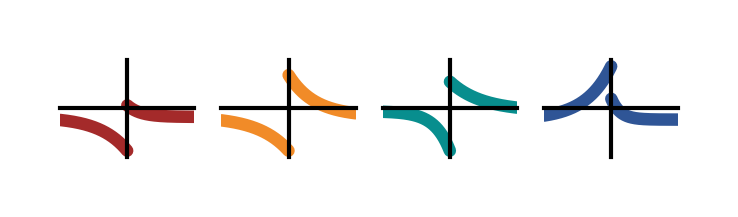

In [9]:
seed = 'f19bec85c2d4104a767b4b821891852d'
ind_seed = np.where(data['seed'] == seed)[0][0]
rule = data[ind_seed]['theta']
aux.plot_4_rules(rule, linewidth=1.5, axwidth=0.5,figsize=(1.33,0.21))

Now let's plot the shape of all the rule quartets in this dataset at once.


/Users/bcfx/Documents/Memory1000Rules/Code/Code_For_Paper/results/aux.py:304: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/aten/src/ATen/native/TensorShape.cpp:3687.)
  rules_tiled = torch.tile(rules, (n_timebins, 1, 1)).T # size [n_rules, n_timebins]


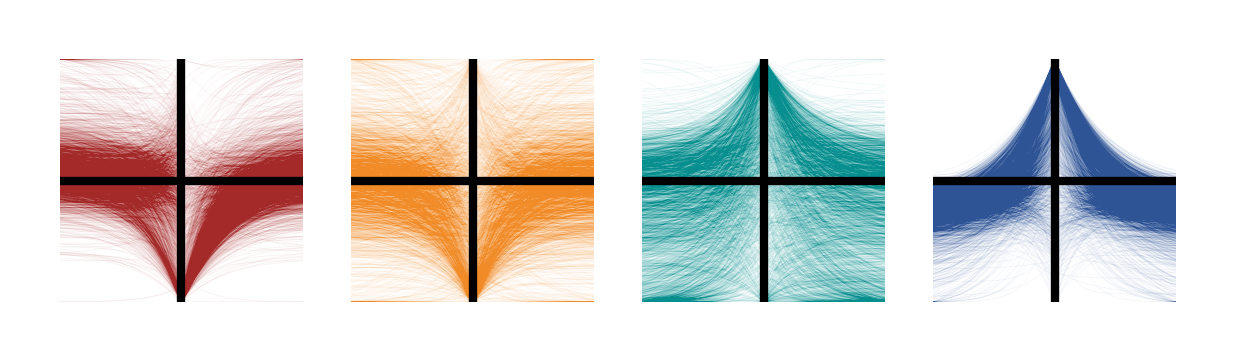

In [10]:
n_timebins = 1000; n_dwbins=1000
dws_ee, dws_ei, dws_ie, dws_ii, dws_hist_norm_ee, dws_hist_norm_ei, dws_hist_norm_ie, dws_hist_norm_ii = aux.get_shape_histogram(data['theta'][:,:-1], n_timebins=n_timebins, n_dwbins=n_dwbins)
aux.plot_4_rules_histogram(dws_hist_norm_ee,
                        dws_hist_norm_ei,
                        dws_hist_norm_ie,
                        dws_hist_norm_ii,
                        cmap_list = [aux.cmap_ee_white, aux.cmap_ei_white, aux.cmap_ie_white, aux.cmap_ii_white],
                        cap=5,
                        figsize=(2.4,0.6),
                        linewidth=1)

We consider a familiarity detection task. In this task, the network is shown one stimulus during training (some input neurons elevate their activity). After a break period with only background inputs that can last from 1s to 4h, the network is shown either a novel stimulus or the training stimulus.
  
Going back to the example rule quartet we plotted two cells above, let's look at the response of a network evolving with this rule quartet on the familiarity task.  
  
1/ After a 10s post-training break  
  
Below is the population firing rate of the excitatory neurons in the network, 10s after the last presentation of the familiar stimulus.  
Between the dotted lines, a novel stimulus is presented for 1s, followed 3s later by the presentation of the familiar (training) stimulus.

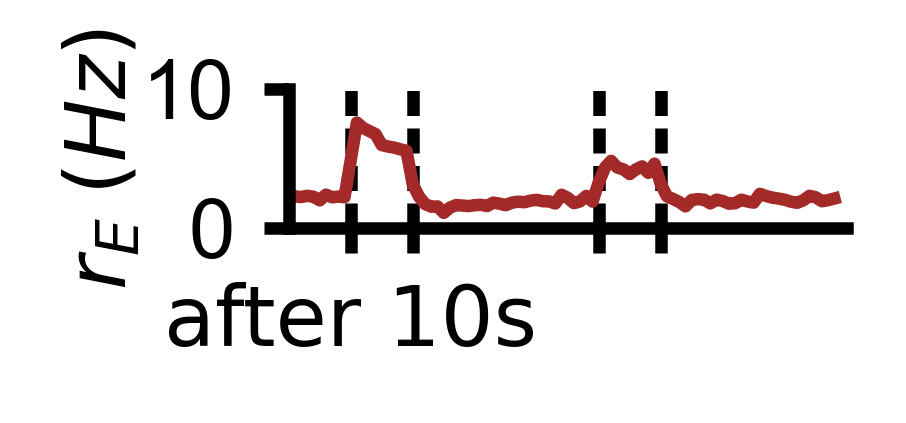

In [48]:
_ = aux.plot_pop_rate(rs = data[ind_seed]["prate"][1,:],
                ts = [i for i in range(data[ind_seed]["prate"].shape[1])],
                t_lim = [0,90],
                y_label = r'$r_E\; (Hz)$',
                r_lim = [0,10],
                color = aux.color_ee,
                x_ticks=[10, 20, 50, 60],
                x_milestones=[10, 20, 50, 60],
                x_ticklabels=['after 10s', '', '', ''],
                x_label = None,
                fontsize = 10,
                linewidth = 1.5,
                axwidth = 1.5,
                save_path = None,
                figsize = (1.2,0.3),
                rotation=0,
                dpi=600,
                target = None)

You can see that the network responds more to the novel stimulus than to the familiar one 10s after training.


2/ After a 4h post-training break

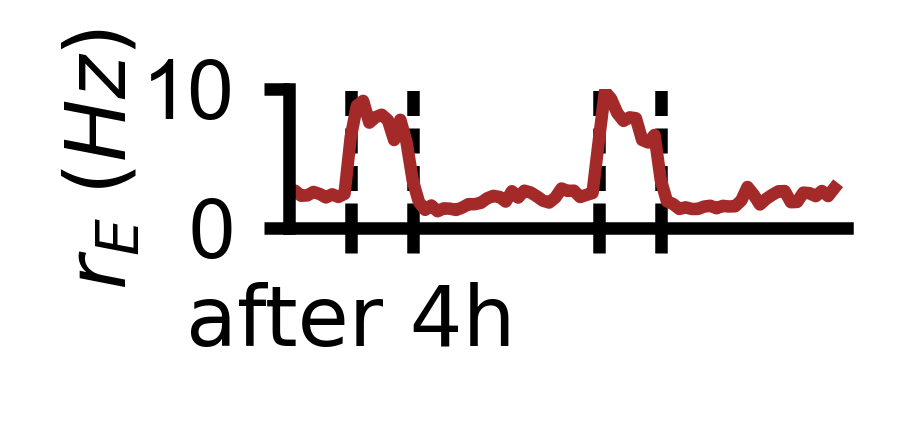

In [38]:
_ = aux.plot_pop_rate(rs = data[ind_seed]["prate"][9,:],
                ts = [i for i in range(data[ind_seed]["prate"].shape[1])],
                t_lim = [0,90],
                y_label = r'$r_E\; (Hz)$',
                r_lim = [0,10],
                color = aux.color_ee,
                x_ticks=[10, 20, 50, 60],
                x_milestones=[10, 20, 50, 60],
                x_ticklabels=['after 4h', '', '', ''],
                x_label = None,
                fontsize = 10,
                linewidth = 1.5,
                axwidth = 1.5,
                save_path = None,
                figsize = (1.2,0.3),
                rotation=0,
                dpi=600,
                target = None)

You can see that this network has a quenched response to the familiar stimulus right after training, but this effect has disappeared after 4h.  
  
We can explore this further by computing the relative strength of the nove response compared to the familiar response (Delta r mem), for all break times tested in these simulations.

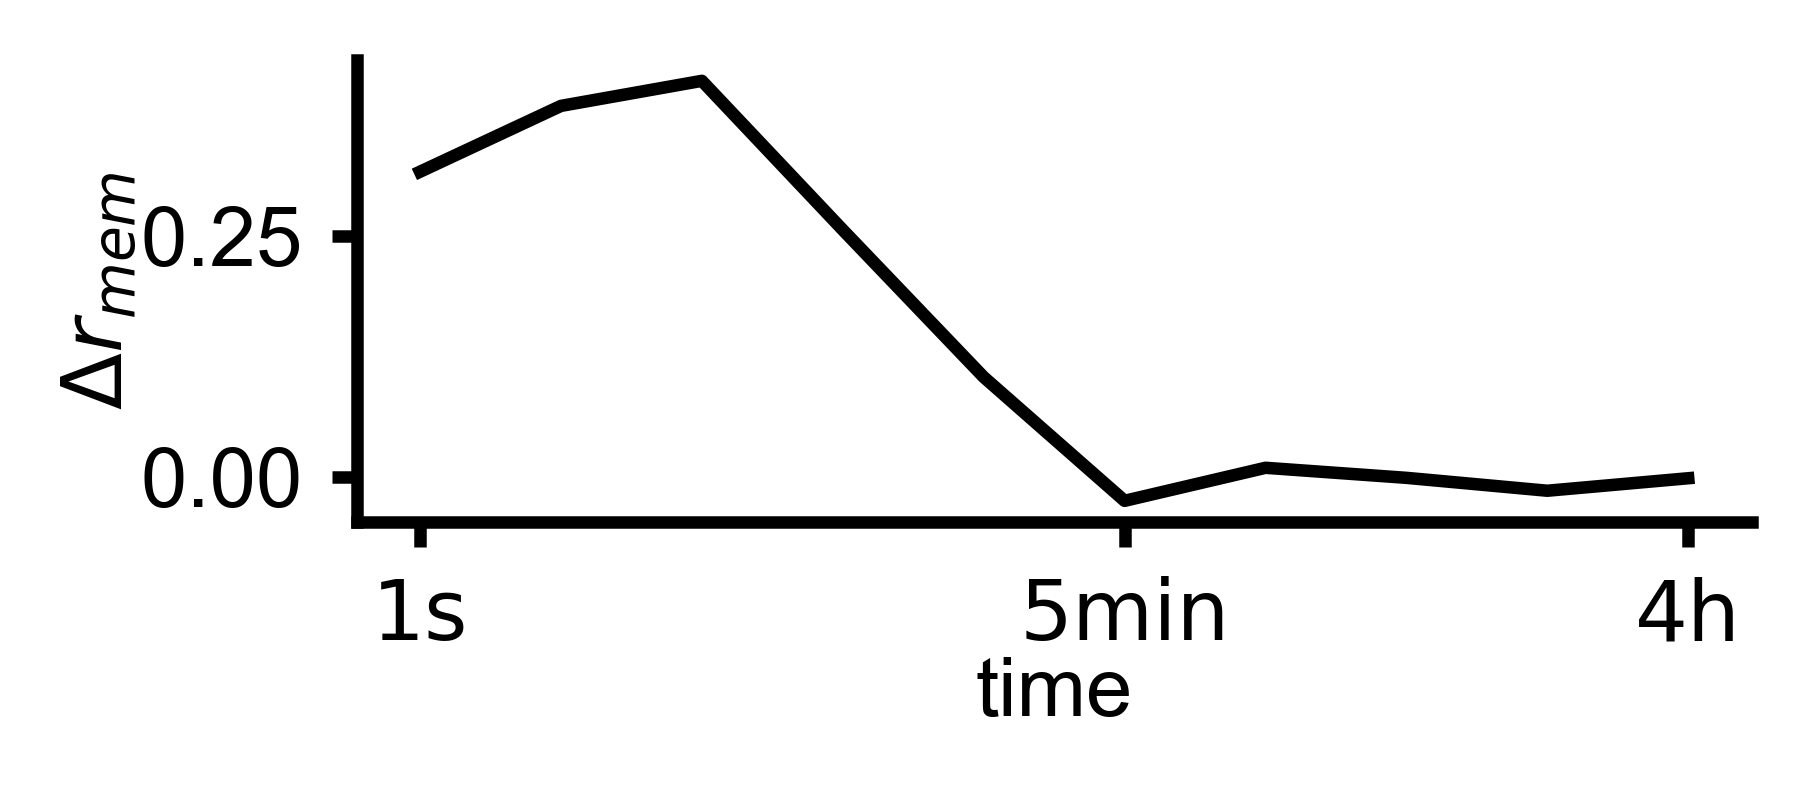

In [15]:
dr = 2*(data['r_nov'] - data['r_fam']) / (data['r_nov'] + data['r_fam']+0.01)
aux.plot_dr_demo(dr[ind_seed])

You can see that the network indeed has a preference for the novel stimulus for a few minutes, and after that forgets the familiar stimulus.

Now let's look at the same rule quartet embedded in a network evolving in the sequential task, during which 5 stimuli are presented sequentially to the network in a loop, followed by a break period with only background input lasting from 1s to 4h, and a test phase during which each training stimulus is presented in isolation to the network, as well as 2 other unseen stimuli.  
  
To plot the network in this task, we are going to fetch the simulated spiketimes for that rule quartet.

In [6]:
sts = np.load('data/Example_ExcSpikes_ReplayRule.npy' , allow_pickle=True).item()

In the sequential task, the stimuli have a certain structure: only 10% of the input neurons elevate their activity when a given stimulus is active. Given the "receptive field" input connectivity (see paper methods), this means that a fraction of neurons in the network will receive much more inputs than others when a given stimulus is active. We call these recurrent neurons "engram" neurons for a given stimulus, which can be defined even if the stimulus has never been shown to the network.  
  
Let's compute who these engram neurons are in our network, and show raster plots (y-axis are different excitatory neurons in the network, x_axis is time) of the network while we present a novel stimulus (signalled by the green line on top of the plot) followed by a familiar stimulus (purple line). The neurons are colored by which engram they belong to. The grey neurons are randomly sampled other neurons, that don't belong to any engram.

After 10s


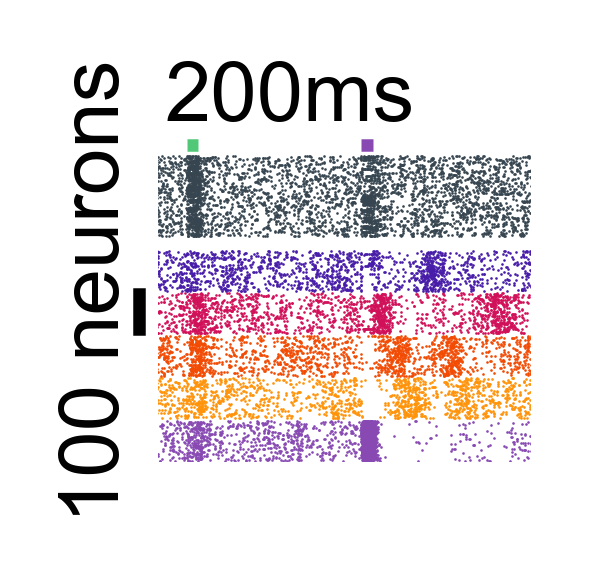

After 4h


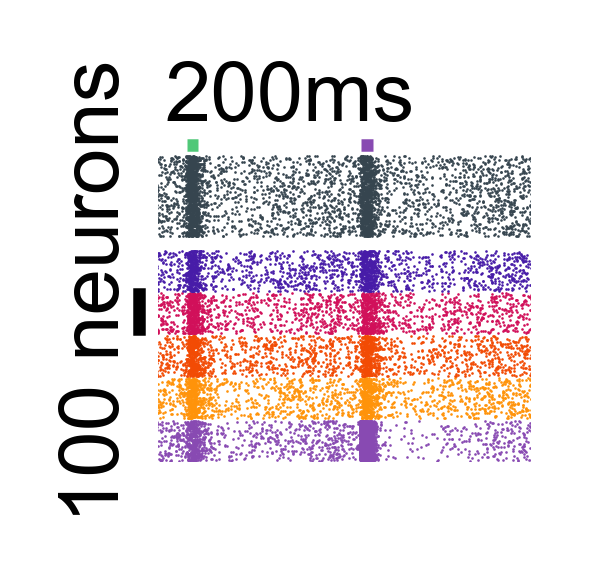

In [5]:
aux.plot_engrams_demo(sts)

You can see above that the presentation of the first familiar stimulus in the sequence (purple) excites the engram neuron for that stimulus (purple neurons). This activates later neurons belonging to engrams of other training stimuli, in a replay-like pattern!  
  
Note that this effect has disappeared after 4h, consistent with our analysis of this rule quartet on the familiarity task.